## All of the imports

In [1]:
import re
import nltk

import pandas as pd
import numpy as np

from os import sep, makedirs
from os.path import dirname, realpath, join, isdir, exists

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_curve
from sklearn.cluster import KMeans
import scikitplot.plotters as skplt

from nltk.corpus import stopwords

import gensim
import itertools
import emoji
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emotlib
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

## Loading the Data

In [2]:
uppath = lambda _path, n: sep.join(_path.split(sep)[:-n]) # moves the path 'n' levels up the directory

__file__ = dirname(realpath('__file__'))
data_parent_directory = uppath(__file__, 2)
data_directory = join(data_parent_directory, 'Data')
root_directory = join(data_directory, 'bag-of-words-meets-bags-of-popcorn')

The data is in the form of a zip file, so we extract CVSs from it.

In [3]:
from zipfile import ZipFile

def extract_data(zipfile_directory, root_directory, zipfile_name):
    
    if not isdir(root_directory):
        makedirs(root_directory)
    
    root_path = join(zipfile_directory, zipfile_name)
    with ZipFile(root_path, 'r') as zip:
            zip.extractall(path=root_directory)

In [4]:
def load_data(root_directory, file_name, delimit=None, quot=0):
    file_path = join(root_directory, file_name)
    return pd.read_csv(file_path, delimiter=delimit, quoting=quot)

In [48]:
extract_data(data_directory, root_directory, 'bag-of-words-meets-bags-of-popcorn.zip')
extract_data(root_directory, root_directory, 'labeledTrainData.tsv.zip')
extract_data(root_directory, root_directory, 'testData.tsv.zip')
extract_data(root_directory, root_directory, 'unlabeledTrainData.tsv.zip')


labeled_train = load_data(root_directory, 'labeledTrainData.tsv', '\t', 3)
unlabeled_train = load_data(root_directory, 'unlabeledTrainData.tsv', '\t', 3)
test = load_data(root_directory, 'testData.tsv', '\t', 3)

In [49]:
labeled_train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


## Exploration & Pre-processing

<ul>The Plan:
<li>Use beautiful soup to remove the HTML tags. See what else that library can do.</li>
<li>Expand contractions using that open-source map.</li>
<li>See if abbreviations are frequent. Like LOL, ASAP, abbrev. etc</li>
<li>Handle punctuations. The 'emoji' library can help remove emojis in the text and replace them with descriptions.</li>
<li>Don't immediately remove the stop words. First see which ones are more frequent and see if they contribute to the sentiment of the review.</li>
<li>Either stem or lemmatize. Maybe this'll affect Word2Vec because we map all inflections to the same stem or root, so the model may lose some contextual information. For example, both the noun and adjective forms of a word could be mapped to the same stem. I'll have to explore this.</li>

In [50]:
#labeled_train['review'][0]

This handles HTML tags.

In [51]:
def clean_reviews(review):
    return BeautifulSoup(review).get_text().strip('"')

labeled_train['clean_review'] = labeled_train['review'].apply(clean_reviews)

C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [52]:
x = "LOL US USA HOLA lol us usa hola L.O.L end.Begin L"
re.findall(r'[A-Z][A-Z.]{2,}', x)

['LOL', 'USA', 'HOLA', 'L.O.L']

Criteria for words to be considered an abbreviation:
<br>1) Must be in all capitals and starts with a letter.
<br>2) Can contain '.'
<br>3) Must be greater than 3 letters in length.

In [53]:
english_words = nltk.corpus.words.words()
abbrev_dict = nltk.FreqDist(abbrev for review in labeled_train['clean_review']
                                           for abbrev in re.findall(r'[A-Z][A-Z.]{2,}', review))

I'll be filtering out the abbreviations by removing common english words from them.
<br>eg:- 'THE' has a high count, but it's not an abbreviation.

In [54]:
real_abbrev_dict = {}
count = 50
value_count = 0
for key, value in  abbrev_dict.most_common():
    if value_count < count:
        if key.lower() not in english_words:
            real_abbrev_dict[key] = value
            value_count+=1

real_abbrev_dict = nltk.FreqDist(real_abbrev_dict)

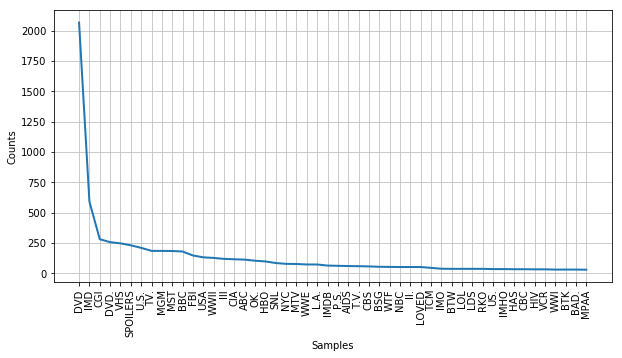

In [55]:
plt.figure(figsize=(10,5))
real_abbrev_dict.plot(count, cumulative=False)

DVD may just mean movie, and other abbreviations don't seem very frequent or important.
<br>Also, if it *is* frequent, a vectorizer will eventually pick it up. So it should be fine.

Note:
<br>This english words corpus is ridiculous. It doesn't have "has" in it. That's why I couldn't check for lowercase words.
<br>Using brown corpus takes ridiculous amount of time. Anyways, I'll ignore abbreviations for now.

---
Let's look at emojis/emoticons
<br>I'm using two libaries for this: emoji and emot

In [56]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    
    '''
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    
    # Removing other punctuations, numbers etc
    text = " ".join(re.findall(r'[a-zA-Z.]+', text))
    '''
    
    return text
# Example
text = "I'm glad :-) 0:-3 0:‑3 ^^)"
convert_emoticons(text)

"I'm glad Happy_face_smiley 0Happy_face_smiley Angel_saint_or_innocent ^^)"

<ul>
<li>If you notice, 0:-3 gives two different results. 
<br>The first one was typed by me and the second one is a key I copy-pasted from the EMOTICONS dictionary. Seems like a problem with "*-*"
<br>Even "emot.emoticons(text)" gives the wrong result.
</li>
<br>
<li>Also, ^^ is not recognized as "Happy face" because they're looking for (^^). Who has the patience to enclose in paranthesis?
<br>I'll be checking for these cases also.
</li>

<br>
<li>The library is buggy, but I'll be using it anyway cause I don't think that level of precision is required here.
<br>It should be fine as long as it gets the simple emoticons right.
</li>
</ul>


As of punctuations, any other special character is irrelevant now, except for the full-stop.
<br>I'm thinking sentences will help the Word2Vec model fetch context better. So the period(.) stays.

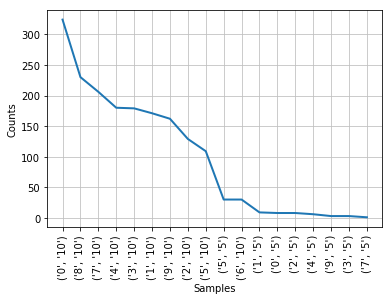

In [57]:
english_words = nltk.corpus.words.words()
abbrev_dict = nltk.FreqDist(abbrev for review in labeled_train['clean_review']
                                        for abbrev in re.findall(r'([0-9])/(5|10)', review))
abbrev_dict.plot(25, cumulative=False)

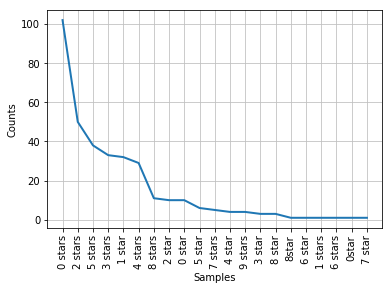

In [58]:
english_words = nltk.corpus.words.words()
abbrev_dict = nltk.FreqDist(abbrev for review in labeled_train['clean_review']
                                        for abbrev in re.findall(r'[0-9]\s*star[s]*', review))
abbrev_dict.plot(25, cumulative=False)

Well, they may not exist for many values, but I could add ratings as a new column.
At least for the records that have a rating, it could be conclusive. I continue this in the Transformation section.

---
Moving on to Stop Words.

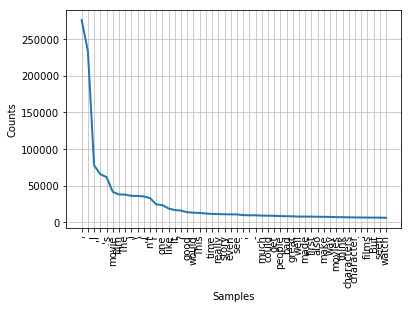

In [59]:
stop_words = stopwords.words('english')
abbrev_dict = nltk.FreqDist(abbrev for review in labeled_train['clean_review']
                                        for abbrev in nltk.word_tokenize(review)
                                            if abbrev not in stop_words)
abbrev_dict.plot(50, cumulative=False)

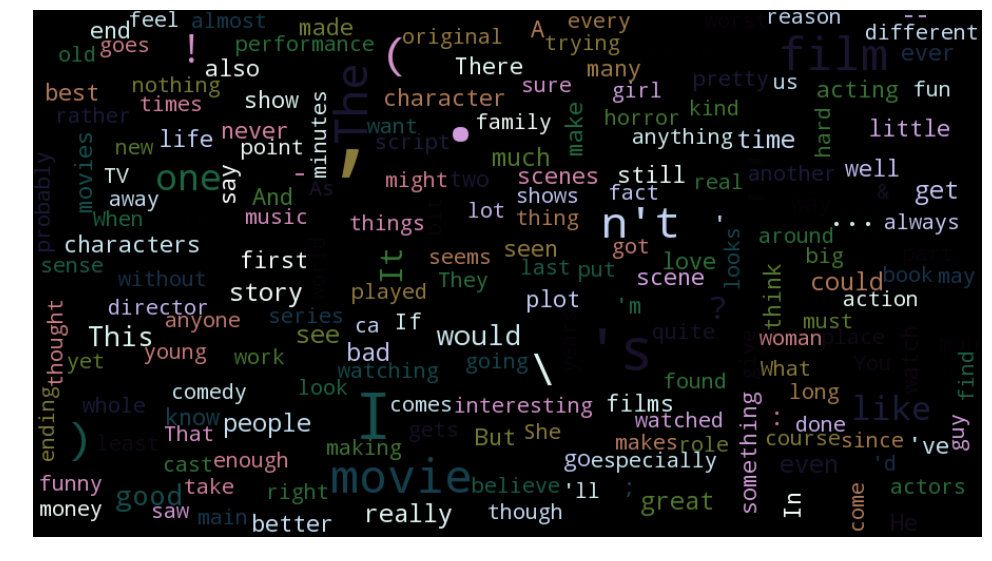

In [60]:
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(abbrev_dict)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

I'm sure once the pre-processing is done, the results above will look more promising.
<br>But again, Word2Vec may use them for context. So I'll keep them for the first iteration.
<br>But if removing helps, then I'll have to be careful not to remove words that affect sentiment.
<br>Eg:- not, won't etc. are part of that stop word list.

---
Next up, normalizing reviews. 
<br>Stemming/Lemmatizing?

In [61]:
test_words = ['liar', 'liars', 'watch', 'watching', 'watched', 'cool', 'cooler', 'coolest', 'original', 'originality', 'differ', 'differentiate', 'differentiation', 'universe', 'universes', 'university', 'universities']

wnl = nltk.WordNetLemmatizer()
[wnl.lemmatize(token) for token in test_words]

['liar',
 'liar',
 'watch',
 'watching',
 'watched',
 'cool',
 'cooler',
 'coolest',
 'original',
 'originality',
 'differ',
 'differentiate',
 'differentiation',
 'universe',
 'universe',
 'university',
 'university']

In [62]:
porter = nltk.PorterStemmer()
[porter.stem(token) for token in test_words]

['liar',
 'liar',
 'watch',
 'watch',
 'watch',
 'cool',
 'cooler',
 'coolest',
 'origin',
 'origin',
 'differ',
 'differenti',
 'differenti',
 'univers',
 'univers',
 'univers',
 'univers']

Seems like it's application dependent.
<br>Stemming is beneficial for condensing the vocabulary: like mapping [watch, watching, watched] -> [watch]. But it's wrong for universities. That's expected.
<br>Lemmatizer doesn't change the inflection of the words, which I believe will help the Word2Vec model.
<br>That's why I'm going to choose lemmatization.

---
#### Alright, let's write-up a function for cleaning our reviews!

In [63]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"c'mon": "come on",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"that'll": "that will",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have",    
"thx"   : "thanks",
}

'''
custom_contractions: has two copies of each key in contractions_dict, one has apostrophe and one doesn't.
Cause people are too lazy to care for grammar and punctuations.
'''
custom_contractions = {}

for contra in contractions:
    custom_contractions[contra] = contractions[contra]
    custom_contractions[contra.replace("'", "")] = contractions[contra]

    
def remove_contractions(review):
    review_tokens = review.split()
    clean_tokens = []
    
    for token in review_tokens:
        if token in custom_contractions.keys():
            token = custom_contractions[token]
        clean_tokens.append(token)
    
    return ' '.join(clean_tokens)

In [8]:
def expand_emoticons_and_emojis(review):
    
    # '?' has a special meaning in regex. But this is improperly escaped, so it ends up saying 'Confusion' for every stray ')'.
    # I'm thus removing it.
    EMOTICONS.pop("\(?_?\)", None)
    
    # Expand emoticons
    for emot in EMOTICONS:
        emoticon = EMOTICONS[emot]
        emoticon = emoticon.replace(",", "")
        emoticon = " ".join(emoticon.split()) # Why split and join? Remove this. 
        review = re.sub(u'('+emot+')', emoticon, review)
        
        # Also checking cases where typed emoticons are not enclosed in (). Gosh! the library is so buggy!
        cleaned_emoticons = []
        if emot.startswith("\\(") and emot.endswith("\\)"):
            for emo in emot.split():
                clean_emo = emo.replace("\\(", "").replace("\\)", "")
                cleaned_emoticons.append(clean_emo)
            
            emot = " ".join(cleaned_emoticons)
            review = re.sub(u'('+emot+')', emoticon, review)
    
    # Expand emojis
    review = emoji.demojize(review)
    review = review.replace(":"," ")
    review = ' '.join(review.split()) # Why split and join? Remove this. 
    review = re.sub("([^\x00-\x7F])+"," ",review)
    
    return review
    

def clean_review(review):
    # Remove HTML content
    review =  BeautifulSoup(review).get_text().strip('"')
    
    # Covert to lower case
    review = review.lower()
    
    # Remove contractions
    review = remove_contractions(review)
    
    # Explain emoticons and emojis in plain words
    review = expand_emoticons_and_emojis(review)
    
    # Lemmatize the review
    lemmatized_review = [wnl.lemmatize(token) for token in nltk.word_tokenize(review)]
    review = " ".join(lemmatized_review)
    
    return review
    
'''
Filters letters: removes every character that is not an alphabet. Call it after you form the rating column. It needs '/' and numbers.
I'm keeping the period(.) to allow for sentence splitting.
'''
def filter_letters(review, removePeriod=False):
    # Removing other punctuations, numbers etc
    pattern = '[^a-zA-Z.\s]+'
    if removePeriod:
        pattern = '[^a-zA-Z\s]+'
        
    review = re.sub(r''+pattern+'', "", review)
    return review

In [65]:
wnl = nltk.WordNetLemmatizer()
labeled_train['clean_review'] = labeled_train['review'].apply(clean_review)
unlabeled_train['clean_review'] = unlabeled_train['review'].apply(clean_review)
test['clean_review'] = test['review'].apply(clean_review)

C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [66]:
#labeled_train['clean_review'][0]

## Feature Engineering

I'll continue with the 'stars' or ratings idea I had before.

In [67]:
def get_stars(review):
    stars = re.findall(r'[0-9]\s*star[s]*', review)
    if(len(stars) > 0):
        return int(stars[0][0])
    else:
        return -1

labeled_train['stars'] = labeled_train['clean_review'].apply(get_stars)

In the case of stars, it's not clear if they're out of 10 or 5.
<br>Using the above stars function, I observe that majority of the star ratings between 0-3 have -ve sentiment and 4-5 have +ve sentiment.
<br>4-5 seems more ambiguous. Understandable, cause 0-2 is bad on both scales.
<br>So I'll assume 0-3 values are on a scale of 10 and leave 4-5 as they're ambiguous.

In [68]:
'''
>= 7 : Good
4-6  : Average
<4   : Bad
None : None
'''
def create_ratings(review):
    ratings = re.findall(r'([0-9])/(5|10)', review)
    stars = re.findall(r'[0-9]\s*star[s]*', review)
    
    total_ratings = 0
    for rating in ratings: # Sum all ratings
        if int(rating[1]) == 5:
            total_ratings += int(rating[0]) * 2
        else:
            total_ratings += int(rating[0])

    stars_count = 0
    for star in stars: # Sum all stars
        if int(star[0]) <=3:
            total_ratings += int(star[0])
            stars_count += 1
    
    if len(ratings) == 0 and stars_count == 0:
        return 'None'
    
    else:    
        # Average all the ratings. Ideally there should only be one per review. I'm hoping so cause average isn't the best approach.
        average_rating = total_ratings / (len(ratings) + stars_count)
        
        if average_rating >= 7:
            return 'Good'
        elif average_rating >=4 and average_rating <= 6:
            return 'Average'
        else:
            return 'Bad'
        
labeled_train['ratings'] = labeled_train['clean_review'].apply(create_ratings)
labeled_train['clean_review'] = labeled_train['clean_review'].apply(filter_letters)

unlabeled_train['ratings'] = unlabeled_train['clean_review'].apply(create_ratings)
unlabeled_train['clean_review'] = unlabeled_train['clean_review'].apply(filter_letters)


test['ratings'] = test['clean_review'].apply(create_ratings)
test['clean_review'] = test['clean_review'].apply(filter_letters)

I also see a few records that mention 'rated' / 'rating', but they're very few. I'll skip them.

---
One hot encode the ratings column
---

I don't see any more columns I could add here.
<br>Even the 'ratings' column will add little value. But I'll let it stay.

## Modeling

Alright, I have this review -> labeled_train['clean_review'][5]
<br>The review says, 'dont know why people think this is such a bad movie. it got a pretty good plot, some good action,'
<br>Negation + negative word -> positive. Here: Dont + bad -> good.
<br>Sometimes negation may be in a different sentence. Eg: They call it bad. But it's good.
<br>I'll have to see if the model I train handles these as well.

I'll be using Word2Vec for this purpose. I also have some scenarios I'd like to test.

In [9]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_list(review, flatten=False):
    
    sentences = sentence_tokenizer.tokenize(review.strip())
    
    if flatten:
        list_of_words = [word
                             for sentence in sentences
                                 for word in nltk.word_tokenize(filter_letters(sentence, True)) 
                                    if len(sentence) > 0]
        return list_of_words
    else:
        list_of_sentences = [nltk.word_tokenize(filter_letters(sentence, True)) 
                                 for sentence in sentences
                                    if len(sentence) > 0]
        return list_of_sentences


sentences = []

for review in labeled_train['clean_review']:
    sentences += review_to_list(review)

for review in unlabeled_train['clean_review']:
    sentences += review_to_list(review)

In [70]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)
print("Saving...")


model_name = "300features_40minwords_10context"
model.save(join(root_directory, model_name))
print("Done...")

model = word2vec.Word2Vec.load(join(root_directory, model_name))

Training model...
Saving...
Done...


There are some cool functions that you can use to check your model's behavior.

In [71]:
model.doesnt_match("hello hi bye".split())
model.similarity("man", "woman")
model.most_similar("man")

c:\users\avinash akella\canopy\notebooks\practice:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
c:\users\avinash akella\canopy\notebooks\practice:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
c:\users\avinash akella\canopy\notebooks\practice:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


[('lady', 0.5485994815826416),
 ('person', 0.5145370960235596),
 ('men', 0.5134139657020569),
 ('businessman', 0.5083885192871094),
 ('lad', 0.4953656792640686),
 ('woman', 0.4901920258998871),
 ('widow', 0.484281063079834),
 ('doctor', 0.47133564949035645),
 ('farmer', 0.4709325432777405),
 ('priest', 0.4573039412498474)]

#### Clustering

Alright, the next few sections I've taken 'inspiration' from this <a href="https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-3-more-fun-with-word-vectors">Kaggle Tutorial</a>. It has a simple, good approach. I'll try that.
<br>I've made few code optimizations, wherever possible, for readability and efficiency.

The tutorial is quoted as follows:
<br><i>Word2Vec creates clusters of semantically related words, so another possible approach is to exploit the similarity of words within a cluster. Grouping vectors in this way is known as 'vector quantization'. To accomplish this, we first need to find the centers of the word clusters, which we can do by using a clustering algorithm such as K-Means.</i>

In [72]:
vocab_list = list(model.wv.vocab.keys())
vocab_vectors = [model[word] for word in vocab_list]

num_clusters = len(vocab_list) // 5

kmeans = KMeans( n_clusters = num_clusters )

clusters = kmeans.fit_predict( vocab_vectors )

c:\users\avinash akella\canopy\notebooks\practice:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Let's print the first ten clusters to see what they're like.

In [73]:
for curr_cluster in range(0,10):
    
    cluster_words = [vocab_list[index] for index in range(0, len(clusters))
                                        if clusters[index] == curr_cluster]
    
    print("Words of Cluster: ", curr_cluster)
    print(cluster_words)

Words of Cluster:  0
['stiller', 'affleck', 'gazzara', 'ben', 'kingsley']
Words of Cluster:  1
['pretext', 'drone', 'periodically', 'playground', 'operates', 'dwelling', 'spying', 'sideline']
Words of Cluster:  2
['laughton', 'silva', 'bronson', 'gerald', 'winninger', 'grodin', 'fagin', 'boyer', 'napier', 'mcdormand', 'durning']
Words of Cluster:  3
['exemplifies', 'celebrates', 'fullest', 'exhibition', 'harshness']
Words of Cluster:  4
['ruled', 'damaged', 'enslaved', 'led', 'occupied', 'conquered', 'destroyed', 'permanently', 'invaded']
Words of Cluster:  5
['visually', 'stylistically', 'technically']
Words of Cluster:  6
['misfire', 'disgrace', 'disaster', 'travesty', 'failure']
Words of Cluster:  7
['escort', 'posing']
Words of Cluster:  8
['overtone', 'symbolism', 'undertone', 'freudian', 'subtext', 'overt', 'undercurrent']
Words of Cluster:  9
['gunfire', 'explosion', 'adrenaline', 'ambush', 'explosive', 'automatic']


Again from the tutorial:
<br><i>At any rate, now we have a cluster (or "centroid") assignment for each word, and we can define a function to convert reviews into bags-of-centroids. This works just like Bag of Words but uses semantically related clusters instead of individual words:</i>

In [10]:
vocab_to_cluster = dict(zip(vocab_list, clusters))
num_centroids = max( clusters ) + 1

'''
Creates a bag of centroids. Basically an array of size = num_centroids.
Each index represents the no of words in that review belonging to that cluster.
'''
def create_bag_of_centroids( review_words ):
    
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    for word in review_words:
        if word in vocab_list:
            index = vocab_to_cluster[word]
            bag_of_centroids[index] += 1
    
    return bag_of_centroids

In [ ]:
total_train_size = labeled_train['clean_review'].size
train_centroids = np.zeros( (total_train_size, num_clusters), dtype="float32" )
test_centroids = np.zeros( ( test['clean_review'].size, num_clusters), dtype="float32" )

counter = 0
for review in labeled_train['clean_review']:
    review_words = review_to_list(review, True)
    train_centroids[counter] = create_bag_of_centroids( review_words )
    counter += 1
    
counter = 0
for review in test['clean_review']:
    review_words = review_to_list(review, True)
    test_centroids[counter] = create_bag_of_centroids( review_words )
    counter += 1

## Evaluation

Let's verify the accuracy using labeled train data

In [ ]:
def evaluate_features(X, y, clf=None):
    
    if clf is None:
        clf = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    
    predictions = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), n_jobs=-1, verbose=2)
    
    print(roc_curve(y, predictions))
    skplt.plot_confusion_matrix(y, predictions)

In [ ]:
def series_to_array(series):
    return series.as_matrix().copy()

In [ ]:
# train_ratings = np.concatenate((series_to_array(labeled_train['ratings']), series_to_array(unlabeled_train['ratings'])))
# train_ratings = train_ratings.reshape(len(train_ratings), 1)
# train_features = np.concatenate((train_centroids, train_ratings.T), axis=1)


train_ratings = series_to_array(labeled_train['ratings'])
train_ratings = train_ratings.reshape(len(train_ratings), 1)
train_features = np.concatenate((train_centroids, train_ratings), axis=1)
train_sentiment = series_to_array(labeled_train['sentiment'])

test_ratings = series_to_array(test['ratings'])
test_ratings = test_ratings.reshape(len(test_ratings), 1)
test_features = np.concatenate((test_centroids, test_ratings), axis=1)

In [ ]:
train_centroids_file = open(join(root_directory, 'train_centroids'),'wb')
pickle.dump(train_centroids_file, train_centroids)
train_centroids_file.close()

test_centroids_file = open(join(root_directory, 'test_centroids'),'wb')
pickle.dump(test_centroids_file, test_centroids)
test_centroids_file.close()

In [ ]:
forest = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
evaluate_features(train_features, train_sentiment, forest)

In [5]:
import pickle

labeled_train = load_data(root_directory, 'copy_labeled_train.csv')
unlabeled_train = load_data(root_directory, 'copy_unlabeled_train.csv')
test = load_data(root_directory, 'copy_test.csv')

clusters_file = open(join(root_directory, 'clusters'),'rb')
clusters = pickle.load(clusters_file)
clusters_file.close()

num_clusters_file = open(join(root_directory, 'num_clusters'),'rb')
num_clusters = pickle.load(num_clusters_file)
num_clusters_file.close()

vocab_list_file = open(join(root_directory, 'vocab_list'),'rb')
vocab_list = pickle.load(vocab_list_file)
vocab_list_file.close()

vocab_vectors_file = open(join(root_directory, 'vocab_vectors'),'rb')
vocab_vectors = pickle.load(vocab_vectors_file)
vocab_vectors_file.close()